##### Ideas: 

1. More carefully select important features. Try linear regression + PCA for this instead of catboost.important_features
2. Leave no more than 8 features, probably 4-5
3. Drop records containing NaN's completely
4. Try different pysr settings according to manual

#### Result:
1. Important features look strange, NAIUP still on top, TAT is not *important*, EGT-something is at the end of the list
2. PCA doesn't help much
3. Gradient boosting overall shows good result, MAE <= 1.0 deg
4. PySR still shows no good formula even with reduced number of arguments, I will return to it later after trying to improve boostings. 


Other notes: 

Hypotesis: egtm = egt redline - egt

Idea: egt redline may depend on engine hours linearly. I want to plot (egt - etgm) vs engine hours 

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
import numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 

dataset = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .sort_values('reportts')

In [3]:
important_features = [
 'egt', 'naiup', 'nait', 'tec', 'aoc', 'ecyc', 'esn', 'ehrs', 'fdp', 'ps14', 'w14', 'egtb'
]

In [4]:
Y = dataset[['egtm']]

X = dataset.drop(columns=[
    'reportts', 'acnum', 'pos', 'dep', 'arr', 
    'egtm', 'fltdes', 'reportts',
    'dmusw', 'exswpn', 'reason'
]).fillna(0)

X = X.loc[:, ~X.columns.str.contains('stw')]

### PCA variance

In [5]:
def get_pca(X, y, n_components=5):
  y = Y['egtm']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)

  scaler = StandardScaler()
  scaler.fit(X_train)

  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  pca = PCA(n_components=n_components)
  pca.fit(X_train)

  X_train = pca.transform(X_train)
  X_test = pca.transform(X_test)

  model = LinearRegression(n_jobs=-1)
  model.fit(X_train, y_train)

  predicted = model.predict(X_test)
  mse = mean_squared_error(y_test, predicted, squared=False)

  return mse, model, pca

As seen from PCA variance plot, this dataset has big variance and cannot be reduced to several dimensions

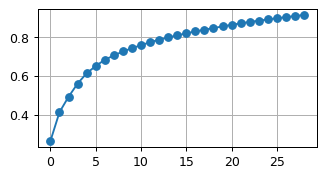

In [6]:
pca_result = []

for n in range(1, 30):
    rmse, model, pca = get_pca(X, Y, n_components=n)
    pca_result.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(4,2), dpi=90)
plt.grid()
plt.plot(pca_result, marker='o')
plt.show()

### Feature importance from Decision tree

Test score: RMSE= 1.2953886646250796 MAE= 0.8386512839917967
Train score: RMSE= 0.6425797333846143 MAE= 0.4929147576379485


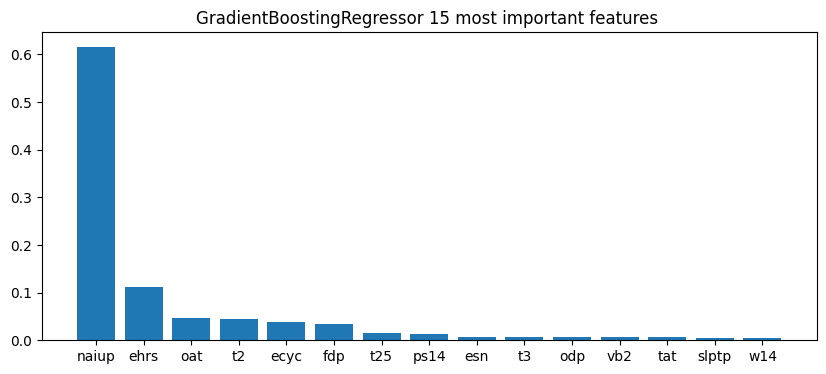

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

def get_feature_importance(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    predicted = model.predict(X_test)
    mse = mean_squared_error(y_test, predicted, squared=False)
    mae = mean_absolute_error(y_test, predicted)

    print("Test score: RMSE=", mse, "MAE=", mae)

    predicted = model.predict(X_train)
    mse = mean_squared_error(y_train, predicted, squared=False)
    mae = mean_absolute_error(y_train, predicted)

    print("Train score: RMSE=", mse, "MAE=", mae)

    return pd.DataFrame({
        'importance': model.feature_importances_, 
        'feature': X.columns
    }).sort_values('importance', ascending=False)

imp = get_feature_importance(X, Y['egtm'])[:15]
plt.figure(figsize=(10, 4))
plt.bar(imp['feature'], imp['importance'])
plt.title('GradientBoostingRegressor 15 most important features ')
plt.show()


In [25]:
important_features = ['naiup', 'ecyc', 'oat', 'fdp', 'ehrs', 'tec', 't2', 'egt', 'egt_peak', 'tat', 'tat_peak']

### Naive feature generation for linreg

In [10]:
def train_model(X, y):
  y = Y['egtm']
  x = X[y.notna()]
  y = y.dropna()

  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=40)

  scaler = StandardScaler()
  scaler.fit(X_train)

  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)

  model = LinearRegression(n_jobs=-1)
  model.fit(X_train, y_train)

  predicted = model.predict(X_test)
  preds = pd.DataFrame({'y': y_test, 'pred': predicted})
  mse = mean_squared_error(y_test, predicted, squared=False)
  mae = mean_absolute_error(y_test, predicted)
  
  return mse, mae, model, preds

In [11]:
mse, mae, result_model, pred = train_model(X, Y)
mse

3.076183887153774

In [12]:
mse, mae, result_model, pred = train_model(X[important_features], Y)
mse

2.972254842820737

Let's add multiplication and square features

In [13]:
X_aug = X[important_features].copy()
for f in important_features:
  X_aug[f + '_2'] = X_aug[f] ** 2
  for k in important_features:
    if f != k:
      X_aug[f + '_m_' + k] = X_aug[f] * X_aug[k]

In [14]:
X_aug.head(3)

,naiup,ecyc,oat,fdp,ehrs,tec,t2,naiup_2,naiup_m_ecyc,naiup_m_oat,...,tec_m_fdp,tec_m_ehrs,tec_m_t2,t2_2,t2_m_naiup,t2_m_ecyc,t2_m_oat,t2_m_fdp,t2_m_ehrs,t2_m_tec
0,128.8,0,1.6,11.3,0,13.0,3.0,16589.44,0.0,206.08,...,146.9,0.0,39.0,9.00,386.40,0.0,4.80,33.90,0.0,39.0
510,127.6,0,1.6,10.4,0,10.0,3.1,16281.76,0.0,204.16,...,104.0,0.0,31.0,9.61,395.56,0.0,4.96,32.24,0.0,31.0
1,129.0,2,9.0,12.0,4,24.0,10.4,16641.00,258.0,1161.00,...,288.0,96.0,249.6,108.16,1341.60,20.8,93.60,124.80,41.6,249.6


In [15]:
mse, mae, result_model, pred = train_model(X_aug, Y)
mse

2.177803939457297

In [16]:
X_aug.head(4)

,naiup,ecyc,oat,fdp,ehrs,tec,t2,naiup_2,naiup_m_ecyc,naiup_m_oat,...,tec_m_fdp,tec_m_ehrs,tec_m_t2,t2_2,t2_m_naiup,t2_m_ecyc,t2_m_oat,t2_m_fdp,t2_m_ehrs,t2_m_tec
0,128.8,0,1.6,11.3,0,13.0,3.0,16589.44,0.0,206.08,...,146.9,0.0,39.0,9.00,386.40,0.0,4.80,33.90,0.0,39.0
510,127.6,0,1.6,10.4,0,10.0,3.1,16281.76,0.0,204.16,...,104.0,0.0,31.0,9.61,395.56,0.0,4.96,32.24,0.0,31.0
1,129.0,2,9.0,12.0,4,24.0,10.4,16641.00,258.0,1161.00,...,288.0,96.0,249.6,108.16,1341.60,20.8,93.60,124.80,41.6,249.6
511,128.3,2,9.0,10.8,4,23.0,10.6,16460.89,256.6,1154.70,...,248.4,92.0,243.8,112.36,1359.98,21.2,95.40,114.48,42.4,243.8


### Equation discovery with PySR

In [17]:
# !pip3 install -U pysr -q
# !python3 -m pysr install

We got 6 important features from Decision Tree `(['naiup', 'ecyc', 'oat', 'fdp', 'ehrs', 'tec'])`, let's try to find a formula for EGTM

In [27]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=1_000, 
    maxdepth=10,
    binary_operators=["*", "+", "-", "/"],
    early_stop_condition=(
        "stop_if(loss, complexity) = loss < 1e-2"
    ),
    unary_operators=[
        "square",
        "inv(x) = 1/x",
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # loss="loss(prediction, target) = (prediction - target)^2",
)

y = Y['egtm']
x = X[important_features]

model.fit(x, y)

/home/b.korzh@group.s7/miniconda3/envs/recsys/lib/python3.9/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/b.korzh@group.s7/miniconda3/envs/recsys/lib/python3.9/site-packages/pysr/sr.py:1937: UserWarning: Note: you are running with 10 features or more. Genetic algorithms like used in PySR scale poorly with large numbers of features. You should run PySR for more `niterations` to ensure it can find the correct variables, or, alternatively, do a dimensionality reduction beforehand. For example, `X = PCA(n_components=6).fit_transform(X)`, using scikit-learn's `PCA` class, will reduce the number of features to 6 in an interpretable way, as each resultant feature will be a linear combination of the original features. 
  warnings.warn(


Compiling Julia backend...


/home/b.korzh@group.s7/miniconda3/envs/recsys/lib/python3.9/site-packages/pysr/julia_helpers.py:208: UserWarning: Your system's Python library is static (e.g., conda), so precompilation will be turned off. For a dynamic library, try using `pyenv` and installing with `--enable-shared`: https://github.com/pyenv/pyenv/blob/master/plugins/python-build/README.md#building-with---enable-shared.
  warnings.warn(


Started!

Expressions evaluated per second: 2.650e+05
Head worker occupation: 15.5%
Progress: 550 / 15000 total iterations (3.667%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.474e+01  1.594e+01  y = 28.663
3           1.814e+01  4.513e-01  y = (-95.039 + naiup)
5           1.663e+01  4.343e-02  y = ((-82.4 + naiup) - fdp)
7           1.507e+01  4.930e-02  y = ((-92.807 + naiup) + (ecyc * -0.006602))
9           1.492e+01  5.132e-03  y = ((-92.807 + naiup) + ((ecyc + oat) * -0.0066003))
11          1.354e+01  4.840e-02  y = (((-40.062 + naiup) + -19.174) - (fdp - (-0.026314 * egt))...
                                  )
13          1.354e+01  4.470e-07  y = (((-40.062 + naiup) + -19.174) - (fdp - (-0.026314 * (egt ...
                                  - -0.12221))))
14          1.354e+01  7.510e-06  y = (((-40.062 + naiup) + -19.174) - (fdp - ((-0.026314 * egt).

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                          28.662846   
	1         4.513065e-01                                (-95.03932 + naiup)   
	2         4.343400e-02                        (-82.39509 + (naiup - fdp))   
	3   >>>>  9.881761e-02        ((naiup - (0.031715404 * egt)) - 67.131096)   
	4         2.023132e-02  (-80.01469 + ((naiup - fdp) - (0.0070707556 * ...   
	5         2.829686e-02  (-73.99838 + ((naiup - fdp) - (0.006892714 * (...   
	6         1.416272e-02  (-69.25867 + ((naiup - fdp) - (0.006260902 * (...   
	7         3.684167e-03  ((-68.38817 + ((naiup - fdp) - (0.0063049267 *...   
	8         8.366477e-08  ((-68.38817 + ((naiup - fdp) - (0.0063049267 *...   
	9         3.008169e-03  (((-68.38817 - -0.8874645) + ((naiup - fdp) - ...   
	10        5.295858e-04  (((-68.38817 - -0.8874645) + ((naiup - fdp) - ...   
	11        3.501973e-04  (((-68.38817 - inv(-0.8874645)) + ((naiup - fd...   
	
	         loss  complexity  
	0   44.737130           1  
	1   18.141293           3  
	2   16.631903           5  
	3   13.649290           7  
	4   13.108028           9  
	5   12.386797          11  
	6   12.040858          13  
	7   11.952463          15  
	8   11.952462          16  
	9   11.916561          17  
	10  11.903946          19  
	11  11.899778          20  
]

In [20]:
model.predict(x)

array([37.4963    , 37.1963    , 36.98215901, ..., 18.13977789,
       23.5236317 , 16.4236317 ])

In [21]:
test = pd.DataFrame({
    'x1': np.random.random(10) * 2,
    'x2': np.random.random(10) * 5,
})

test['y'] = -10.4 * (test['x1'] ** 2) + 35 * test['x1'] * test['x2'] - 45.5

In [22]:
# model2 = PySRRegressor(
#     niterations=100,
#     binary_operators=["*", "+", "-", "/"],
#     unary_operators=[
#         "square", "cube"
#         # "cos",
#         # "exp",
#         # "sin",
#         # "inv(x) = 1/x",
#     ],
#     # extra_sympy_mappings={"inv": lambda x: 1 / x},
#     loss="loss(prediction, target) = (prediction - target)^2",
# )

# model2.fit(test[['x1', 'x2']], test['y'])